Regressing a function with lot's of local minimmas using Fully Connected Neural Network (MLP),
for Advanced Deep Learning Course, Fall 2023,

Programmed by Ardavan Modarres
ardavan.modarres@email.kntu.ac.ir
* 2023-10-04: Initial coding

In [2]:
# Imports
import torch
import torch.nn.functional as F              # Parameterless functions, like (some) activation functions
import torchvision.datasets as datasets      # Standard datasets
import torchvision.transforms as transforms  # Transformations we can perform on our dataset for augmentation
from torch import optim                      # For optimizers like SGD, Adam, etc.
from torch import nn                         # All neural network modules
from torch.utils.data import DataLoader, Dataset
                                            # Gives easier dataset managment by creating mini batches etc.
from tqdm import tqdm                        # For nice progress bar!

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sn

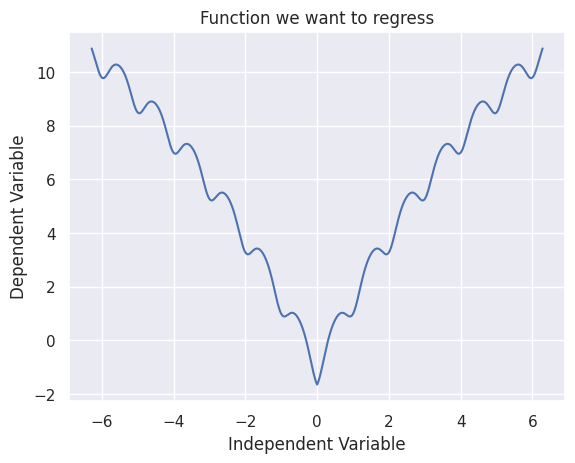

In [3]:
sn.set_theme(style="darkgrid")
x = np.linspace(-2*np.pi, 2*np.pi, 2500)
y = -20.0*np.exp(-0.2*np.sqrt(0.5*(x**2)))-np.exp(0.5*(np.cos(2*np.pi*x)))+20

plt.plot(x, y)
plt.title('Function we want to regress')
plt.xlabel("Independent Variable")
plt.ylabel("Dependent Variable")
plt.show()

In [4]:
class RegressionDataset(Dataset):
    def __init__(self):
        self.x = torch.from_numpy(x).to(torch.float32).reshape(-1, 1)
        self.y = torch.from_numpy(y).to(torch.float32).reshape(-1, 1)
    # support indexing such that dataset[i] can be used to get i-th sample
    def __getitem__(self, index):
        return self.x[index], self.y[index]
    # we can call len(dataset) to return the size
    def __len__(self):
        return self.x.shape[0]

ds = RegressionDataset()
print(len(ds))
print(ds[0][0], ds[0][1])

2500
tensor([-6.2832]) tensor([10.8735])


In [5]:
# Set device cuda for GPU if it's available otherwise run on the CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Hyperparameters
input_size = 1
num_output = 1
learning_rate = 4e-3
batch_size = 64
num_epochs = 240

In [6]:
dataset = RegressionDataset()
train_set, validation_set, test_set = torch.utils.data.random_split(dataset, [0.8, 0.1, 0.1])
train_loader = DataLoader(dataset=train_set, batch_size=batch_size, shuffle=True)
validation_loader = DataLoader(dataset=validation_set, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(dataset=test_set, batch_size=batch_size, shuffle=False)

In [7]:
class NN(nn.Module):
    def __init__(self, input_size, num_output):
        """
        Here we define the layers of the network. We create two fully connected layers
        Parameters:
            input_size: the size of the input, in this case 784 (28x28)
            num_classes: the number of classes we want to predict, in this case 10 (0-9)
        """
        super(NN, self).__init__()
        # Our first linear layer take input_size, in this case 784 nodes to 50
        # and our second linear layer takes 50 to the num_classes we have, in
        # this case 10.
        self.fc1 = nn.Linear(input_size, 256)
        self.fc2 = nn.Linear(256, 256)
        self.fc3 = nn.Linear(256, 256)
        self.fc4 = nn.Linear(256, num_output)

    def forward(self, x):
        """
        x here is the mnist images and we run it through fc1, fc2 that we created above.
        we also add a ReLU activation function in between and for that (since it has no parameters)
        I recommend using nn.functional (F)
        Parameters:
            x: mnist images
        Returns:
            out: the output of the network
        """

        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = self.fc4(x)
        return x

In [8]:
def get_info(model, loader):
  batch_loss = []
  epoch_loss = []
  model.eval()
  with torch.no_grad():
    for (data, targets) in loader:
      # Get data to device
      data = data.to(device=device)
      targets = targets.to(device=device)
      # Forward
      preds = model(data)
      loss = criterion(preds, targets)
      # Taking record of losses
      batch_loss.append(loss.item())
  model.train()
  return sum(batch_loss)/len(batch_loss)

In [9]:
# Train Network
def Train(model, device, criterion, optimizer, num_epochs):
  train_loss = []
  validation_loss = []
  for epoch in range(num_epochs):
      for batch_idx, (data, targets) in enumerate(tqdm(train_loader)):
          # Get data to device
          data = data.to(device=device)
          targets = targets.to(device=device)
          # Forward
          preds = model(data)
          loss = criterion(preds, targets)
          # Backward
          optimizer.zero_grad()
          loss.backward()
          # Gradient descent or adam step
          optimizer.step()

      # Taking record of losses
      tr_loss = get_info(model, train_loader)
      val_loss = get_info(model, validation_loader)
      train_loss.append(tr_loss)
      validation_loss.append(val_loss)

  plt.plot(train_loss)
  plt.plot(validation_loss)
  plt.title("Performance/Loss")
  plt.legend(['Train Loss', 'Validation Loss'])
  plt.xlabel("Epoch")
  plt.ylabel("Loss")
  plt.show()

In [10]:
# # Train Network
# def Train(model, device, criterion, optimizer, num_epochs):
#   for epoch in range(num_epochs):
#       for batch_idx, (data, targets) in enumerate(tqdm(train_loader)):
#           # Get data to cuda if possible
#           data = data.to(device=device)
#           targets = targets.to(device=device)
#           # Forward
#           scores = model(data)
#           loss = criterion(scores, targets)

#           # Backward
#           optimizer.zero_grad()
#           loss.backward()

#           # Gradient descent or adam step
#           optimizer.step()

In [11]:
# Initialize network
model = NN(input_size=input_size, num_output=num_output).to(device)

# Loss and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

100%|██████████| 32/32 [00:00<00:00, 145.67it/s]


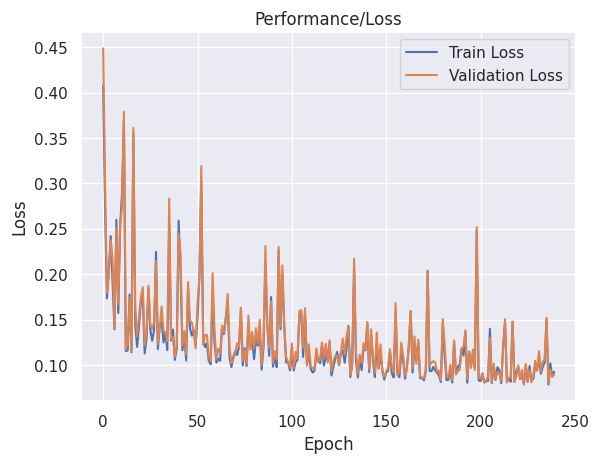

In [12]:
Train(model, device, criterion, optimizer, num_epochs)

In [13]:
train_input = torch.zeros(len(train_set), 1)
train_preds = torch.zeros(len(train_set), 1)
test_input = torch.zeros(len(test_set), 1)
test_preds = torch.zeros(len(test_set), 1)

def get_embeddings(model, loader, input, target):
  model.eval()

  pointer = 0
  with torch.no_grad():
    for x, y in loader:
      x = x.to(device)
      y = y.to(device)
      input[pointer:pointer + x.shape[0]] = x
      target[pointer:pointer + x.shape[0]] = model(x)
      pointer+=x.shape[0]

  model.train()
  return input, target

train_input, train_preds = get_embeddings(model, train_loader, train_input, train_preds)
test_input, test_preds = get_embeddings(model, test_loader, test_input, test_preds)

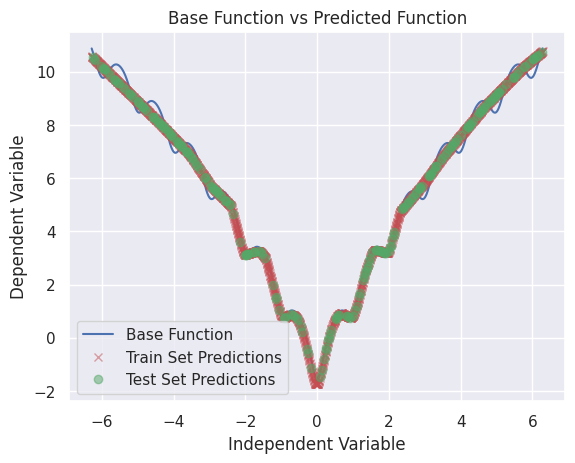

In [14]:
plt.plot(x, y)
plt.plot(train_input, train_preds, 'rx', alpha=0.5)
plt.plot(test_input, test_preds, 'go', alpha=0.5)
plt.title('Base Function vs Predicted Function')
plt.xlabel("Independent Variable")
plt.ylabel("Dependent Variable")
plt.legend(['Base Function', 'Train Set Predictions', 'Test Set Predictions'])
plt.show()

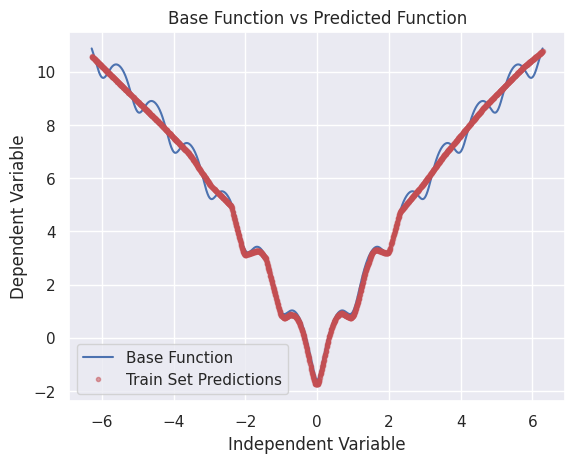

In [15]:
plt.plot(x, y)
plt.plot(train_input, train_preds, 'r.', alpha=0.5)
plt.title('Base Function vs Predicted Function')
plt.xlabel("Independent Variable")
plt.ylabel("Dependent Variable")
plt.legend(['Base Function', 'Train Set Predictions'])
plt.show()

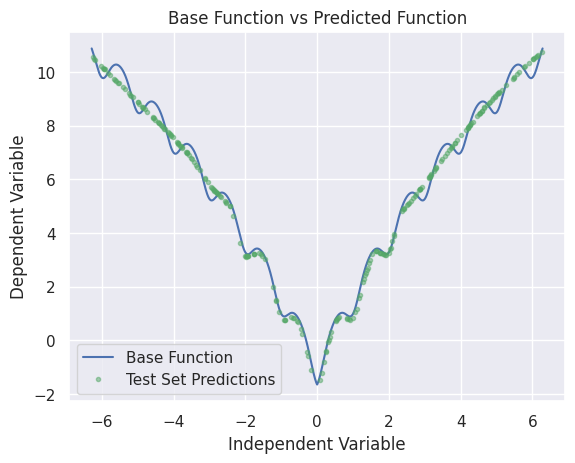

In [16]:
plt.plot(x, y)
plt.plot(test_input, test_preds, 'g.', alpha=0.5)
plt.title('Base Function vs Predicted Function')
plt.xlabel("Independent Variable")
plt.ylabel("Dependent Variable")
plt.legend(['Base Function', 'Test Set Predictions'])
plt.show()

### Having all plots together

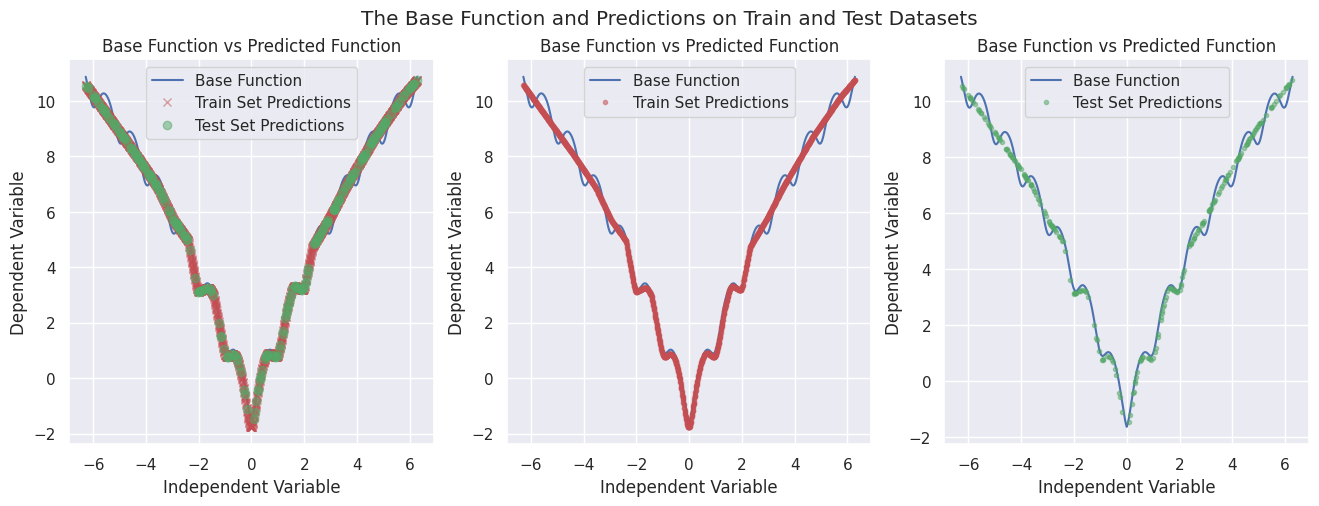

In [17]:
#plot 1:
plt.figure(figsize=(16, 5))
plt.subplot(1, 3, 1)
plt.plot(x, y)
plt.plot(train_input, train_preds, 'rx', alpha=0.5)
plt.plot(test_input, test_preds, 'go', alpha=0.5)
plt.title('Base Function vs Predicted Function')
plt.xlabel("Independent Variable")
plt.ylabel("Dependent Variable")
plt.legend(['Base Function', 'Train Set Predictions', 'Test Set Predictions'])

#plot 2:
plt.subplot(1, 3, 2)
plt.plot(x, y)
plt.plot(train_input, train_preds, 'r.', alpha=0.5)
plt.title('Base Function vs Predicted Function')
plt.xlabel("Independent Variable")
plt.ylabel("Dependent Variable")
plt.legend(['Base Function', 'Train Set Predictions'])

#plot 3:
plt.subplot(1, 3, 3)
plt.plot(x, y)
plt.plot(test_input, test_preds, 'g.', alpha=0.5)
plt.title('Base Function vs Predicted Function')
plt.xlabel("Independent Variable")
plt.ylabel("Dependent Variable")
plt.legend(['Base Function', 'Test Set Predictions'])
plt.suptitle("The Base Function and Predictions on Train and Test Datasets")
plt.show()

## Using powers of input x as some new features :

In [18]:
x = np.linspace(-2*np.pi, 2*np.pi, 2500)
y = -20.0*np.exp(-0.2*np.sqrt(0.5*(x**2)))-np.exp(0.5*(np.cos(2*np.pi*x)))+20

In [19]:
# Generating powers of x
x_cp = np.copy(x).reshape((-1, 1))
y_cp = np.copy(y)
for i in range(2, 6):
  x_cp = np.concatenate((x_cp, (x**i).reshape((-1, 1))), 1)
print(x_cp.shape)

(2500, 5)


In [20]:
## New split
def split(x, y, train_percentage):
  x_temp = np.copy(x)
  y_temp = np.copy(y)
  random_idxs = np.random.permutation(x_temp.shape[0])
  x_temp = x_temp[random_idxs]
  y_temp = y_temp[random_idxs]
  num_train = int(train_percentage*x.shape[0])
  return x_temp[:num_train], x_temp[num_train:], y_temp[:num_train], y_temp[num_train:]

In [21]:
x_train, x_test, y_train, y_test = split(x_cp, y_cp, .8)

x_train_min = np.amin(x_train, axis=0)
x_train_max = np.amax(x_train, axis=0)

y_train_min = np.amin(y_train, axis=0)
y_train_max = np.amax(y_train, axis=0)

normalized_x_train = (x_train - x_train_min)/(x_train_max - x_train_min)
normalized_x_test = (x_test - x_train_min)/(x_train_max - x_train_min)
normalized_y_train = (y_train - y_train_min)/(y_train_max - y_train_min)
normalized_y_test = (y_test - y_train_min)/(y_train_max - y_train_min)


# normalized_x_train = (x_train - np.amin(x_train, axis=0))/(np.amax(x_train, axis=0) - np.amin(x_train, axis=0))
# normalized_x_test = (x_test - np.amin(x_train, axis=0))/(np.amax(x_train, axis=0) - np.amin(x_train, axis=0))

print("min and max of train set : ", normalized_x_train.min(), normalized_x_train.max())
print("min and max of test set : ", normalized_x_test.min(), normalized_x_test.max())

print("min and max of train target : ", normalized_y_train.min(), normalized_y_train.max())
print("min and max of test target: ", normalized_y_test.min(), normalized_y_test.max())

min and max of train set :  0.0 1.0
min and max of test set :  2.051280079423069e-12 0.9995998399359745
min and max of train target :  0.0 1.0
min and max of test target:  0.001201381209179485 0.9984067002194665


In [22]:
class RegressionDataset(Dataset):
    def __init__(self, x, y):
        self.x = torch.from_numpy(x).to(torch.float32)#.reshape(-1, 1)
        self.y = torch.from_numpy(y).to(torch.float32).reshape(-1, 1)
    # support indexing such that dataset[i] can be used to get i-th sample
    def __getitem__(self, index):
        return self.x[index], self.y[index]
    # we can call len(dataset) to return the size
    def __len__(self):
        return self.x.shape[0]

# ds = RegressionDataset()
# print(len(ds))
# print(ds[0].shape, ds[0][1])

In [23]:
train_set = RegressionDataset(normalized_x_train, normalized_y_train)
validation_set = RegressionDataset(normalized_x_test, normalized_y_test)

train_loader = DataLoader(dataset=train_set, batch_size=batch_size, shuffle=True)
validation_loader = DataLoader(dataset=validation_set, batch_size=batch_size, shuffle=False)


print("Length of train Set : ", len(train_set))
print("Length of test Set : ", len(validation_set))
print(train_set[0][0].shape, train_set[0][1])

Length of train Set :  2000
Length of test Set :  500
torch.Size([5]) tensor([0.3033])


In [24]:
# Set device cuda for GPU if it's available otherwise run on the CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Hyperparameters
input_size = 5
num_output = 1
learning_rate = 4e-3
batch_size = 64
num_epochs = 100

In [25]:
class NN(nn.Module):
    def __init__(self, input_size, num_output):
        """
        Here we define the layers of the network. We create two fully connected layers
        Parameters:
            input_size: the size of the input, in this case 784 (28x28)
            num_classes: the number of classes we want to predict, in this case 10 (0-9)
        """
        super(NN, self).__init__()
        # Our first linear layer take input_size, in this case 784 nodes to 50
        # and our second linear layer takes 50 to the num_classes we have, in
        # this case 10.
        self.fc1 = nn.Linear(input_size, 256)
        self.fc2 = nn.Linear(256, 256)
        self.fc3 = nn.Linear(256, 256)
        self.fc4 = nn.Linear(256, num_output)

    def forward(self, x):
        """
        x here is the mnist images and we run it through fc1, fc2 that we created above.
        we also add a ReLU activation function in between and for that (since it has no parameters)
        I recommend using nn.functional (F)
        Parameters:
            x: mnist images
        Returns:
            out: the output of the network
        """

        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = self.fc4(x)
        return x

In [26]:
# # Train Network
# def Train(model, device, criterion, optimizer, num_epochs):
#   for epoch in range(num_epochs):
#       for batch_idx, (data, targets) in enumerate(tqdm(train_loader)):
#           # Get data to cuda if possible
#           data = data.to(device=device)
#           targets = targets.to(device=device)
#           # Forward
#           scores = model(data)
#           loss = criterion(scores, targets)

#           # Backward
#           optimizer.zero_grad()
#           loss.backward()

#           # Gradient descent or adam step
#           optimizer.step()

In [27]:
# Initialize network
model = NN(input_size=input_size, num_output=num_output).to(device)

# Loss and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

100%|██████████| 32/32 [00:00<00:00, 125.99it/s]


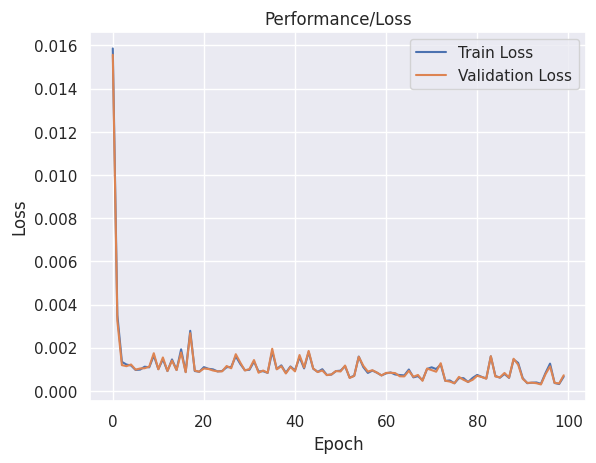

In [28]:
Train(model, device, criterion, optimizer, num_epochs)

In [29]:
train_input = torch.zeros(len(train_set), 5)
train_preds = torch.zeros(len(train_set), 1)
validation_input = torch.zeros(len(validation_set), 5)
validation_preds = torch.zeros(len(validation_set), 1)

def get_embeddings(model, loader, input, target):
  model.eval()

  pointer = 0
  with torch.no_grad():
    for x, y in loader:
      x = x.to(device)
      y = y.to(device)
      input[pointer:pointer + x.shape[0]] = x
      # print(model(x).shape)
      target[pointer:pointer + x.shape[0]] = model(x)
      pointer+=x.shape[0]

  model.train()
  return input, target

train_input, train_preds = get_embeddings(model, train_loader, train_input, train_preds)
validation_input, validation_preds = get_embeddings(model, validation_loader, validation_input, validation_preds)

### Denormalization

In [30]:
denorm_train_input = train_input[:, 0]*(x_train_max[0] - x_train_min[0]) + x_train_min[0]
denorm_validation_input = validation_input[:, 0]*(x_train_max[0] - x_train_min[0]) + x_train_min[0]

denorm_train_preds = train_preds*(y_train_max - y_train_min) + y_train_min
denorm_validation_preds = validation_preds*(y_train_max - y_train_min) + y_train_min

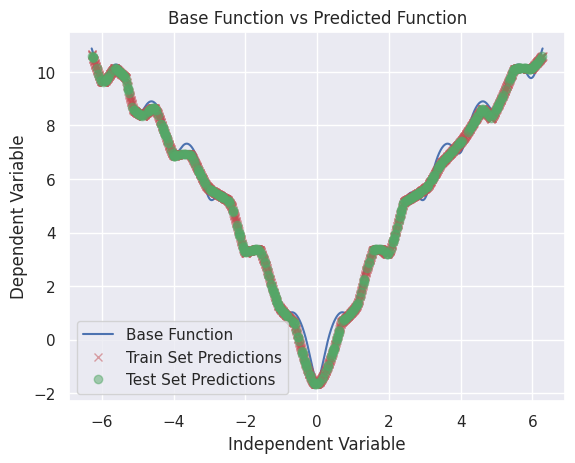

In [31]:
plt.plot(x, y)
plt.plot(np.sort(denorm_train_input), denorm_train_preds[np.argsort(denorm_train_input)], 'rx', alpha=0.5)
plt.plot(np.sort(denorm_validation_input), denorm_validation_preds[np.argsort(denorm_validation_input)], 'go', alpha=0.5)
plt.title('Base Function vs Predicted Function')
plt.xlabel("Independent Variable")
plt.ylabel("Dependent Variable")
plt.legend(['Base Function', 'Train Set Predictions', 'Test Set Predictions'])
plt.show()

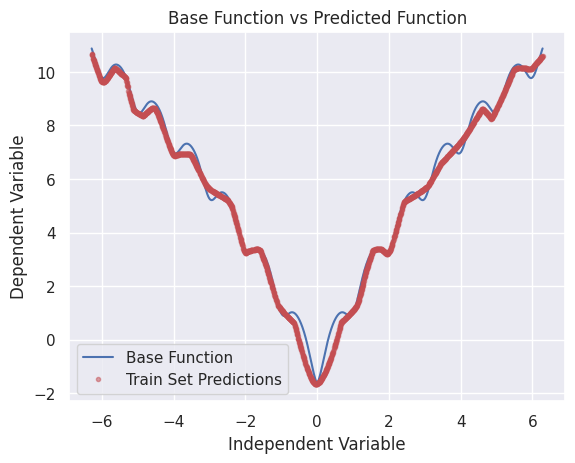

In [32]:
plt.plot(x, y)
plt.plot(np.sort(denorm_train_input), denorm_train_preds[np.argsort(denorm_train_input)], 'r.', alpha=0.5)
plt.title('Base Function vs Predicted Function')
plt.xlabel("Independent Variable")
plt.ylabel("Dependent Variable")
plt.legend(['Base Function', 'Train Set Predictions'])
plt.show()

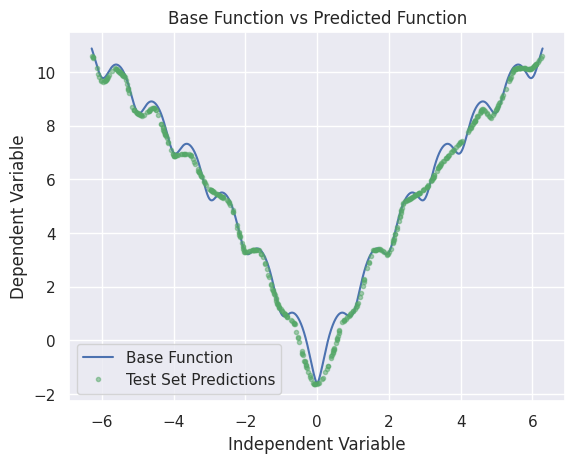

In [33]:
plt.plot(x, y)
plt.plot(np.sort(denorm_validation_input), denorm_validation_preds[np.argsort(denorm_validation_input)], 'g.', alpha=0.5)
plt.title('Base Function vs Predicted Function')
plt.xlabel("Independent Variable")
plt.ylabel("Dependent Variable")
plt.legend(['Base Function', 'Test Set Predictions'])
plt.show()

### Having all plots together

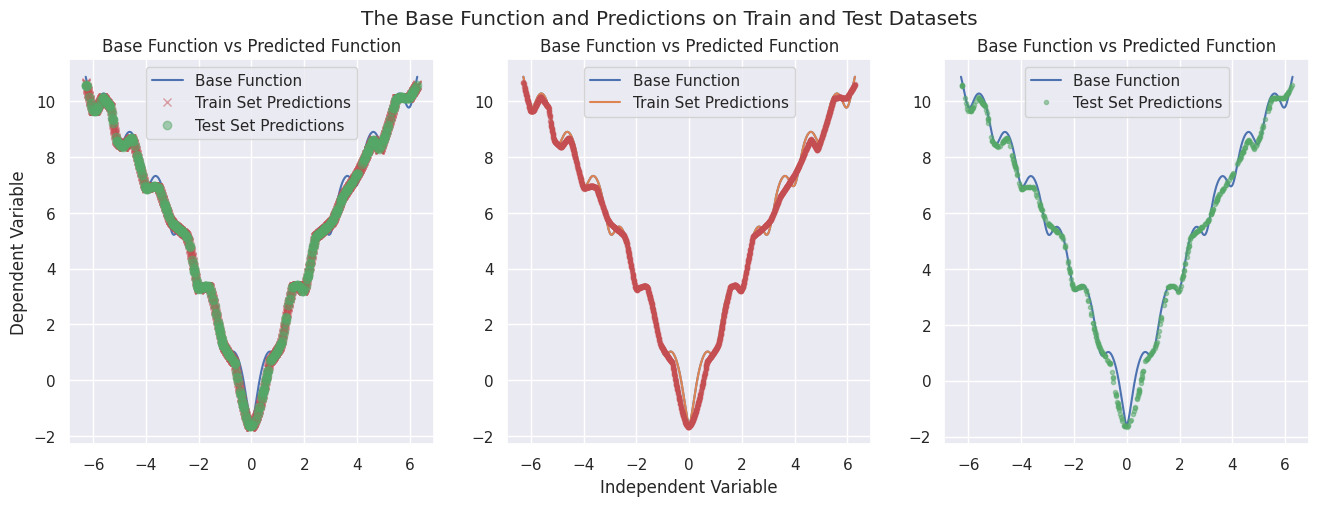

In [34]:
#plot 1:
plt.figure(figsize=(16, 5))
plt.subplot(1, 3, 1)
plt.plot(x, y)
plt.plot(np.sort(denorm_train_input), denorm_train_preds[np.argsort(denorm_train_input)], 'rx', alpha=0.5)
plt.plot(np.sort(denorm_validation_input), denorm_validation_preds[np.argsort(denorm_validation_input)], 'go', alpha=0.5)
plt.title('Base Function vs Predicted Function')

plt.ylabel("Dependent Variable")
plt.legend(['Base Function', 'Train Set Predictions', 'Test Set Predictions'])

#plot 2:
plt.subplot(1, 3, 2)
plt.plot(x, y)
plt.plot(x, y)
plt.plot(np.sort(denorm_train_input), denorm_train_preds[np.argsort(denorm_train_input)], 'r.', alpha=0.5)
plt.title('Base Function vs Predicted Function')
plt.xlabel("Independent Variable")

plt.legend(['Base Function', 'Train Set Predictions'])


#plot 3:
plt.subplot(1, 3, 3)
plt.plot(x, y)
plt.plot(np.sort(denorm_validation_input), denorm_validation_preds[np.argsort(denorm_validation_input)], 'g.', alpha=0.5)
plt.title('Base Function vs Predicted Function')
plt.legend(['Base Function', 'Test Set Predictions'])
plt.suptitle("The Base Function and Predictions on Train and Test Datasets")
plt.show()